In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.path as mpath

import xgcm

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pprint import pprint
import importlib

import geopy
from geopy import distance

In [2]:
#download the ECCO grid file

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|#########################| 1/1 [00:00<00:00, 9986.44it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
vol_monthly_shortname = "ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vol_monthly_shortname,\
                    StartDate="2000-01-02",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-02,2000-12-31'}

Total number of matching granules: 12
DL Progress: 100%|#########################| 12/12 [00:12<00:00,  1.00s/it]

total downloaded: 367.24 Mb
avg download speed: 30.44 Mb/s


In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load vector fields
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VOLUME*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

pprint(ecco_ds.data_vars)

Data variables:
    CS        (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN        (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    rA        (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    dxG       (tile, j_g, i) float32 1.558e+04 1.559e+04 ... 2.36e+04 2.314e+04
    dyG       (tile, j, i_g) float32 2.321e+04 2.327e+04 ... 1.56e+04 1.558e+04
    Depth     (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rAz       (tile, j_g, i_g) float32 1.799e+08 1.805e+08 ... 3.642e+08
    dxC       (tile, j, i_g) float32 1.558e+04 1.559e+04 ... 2.387e+04 2.341e+04
    dyC       (tile, j_g, i) float32 1.156e+04 1.159e+04 ... 1.559e+04 1.558e+04
    rAw       (tile, j, i_g) float32 3.617e+08 3.628e+08 ... 3.722e+08 3.648e+08
    rAs       (tile, j_g, i) float32 1.802e+08 1.807e+08 ... 3.678e+08 3.605e+08
    drC       (k_p1) float32 5.0 10.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.2
    drF       (k) float32 10.

In [8]:
delta_range = [1, 1/2, 1/4]
#, 1/8, 1/16, 1/32, 1/64
N_delta = len(delta_range)

lat_edges = np.array([[32.5, 34.5],   [33.25, 34.25],   [33.625, 34.125]])
lon_edges = np.array([[-68.5, -66.5], [-67.75, -66.75], [-67.375, -66.875]])
#[33.8125, 34.0625], [33.90625, 34.03125], [33.953125, 34.015625], [33.9765625, 34.0078125]
#[-67.1875, -66.9375], [-67.09375, -66.96875], [-67.046875, -66.984375], [-67.0234375, -66.9921875]

SPEED_slice = {}
lat_slice   = {}
lon_slice   = {}
dist_slice = {}

for idelta, delta in enumerate(delta_range):
    Nh    = int(5/delta + 1)
    SPEED = np.zeros(Nh)
    lat   = np.zeros(Nh)
    lon   = np.zeros(Nh)
    dist  = np.zeros(Nh)
    
    for i in range (0, Nh):
        new_grid_min_lat = lat_edges[idelta, 0] + delta * i
        new_grid_max_lat = lat_edges[idelta, 1] + delta * i

        new_grid_min_lon = lon_edges[idelta, 0] - delta * i
        new_grid_max_lon = lon_edges[idelta, 1] - delta * i

        xfld = ecco_ds.UVELMASS.isel(k=0, time=0)
        yfld = ecco_ds.VVELMASS.isel(k=0, time=0)

        # Compute the zonal and meridional vector components of oceTAUX and oceTAUY
        VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)

        # interpolate to lat-lon
        new_grid_lon_centers, new_grid_lat_centers,\
        new_grid_lon_edges, new_grid_lat_edges,\
        VEL_E_latlon =\
                ecco.resample_to_latlon(ecco_grid.XC, \
                                        ecco_grid.YC, \
                                        VEL_E,\
                                        new_grid_min_lat, new_grid_max_lat, delta,\
                                        new_grid_min_lon, new_grid_max_lon, delta,\
                                        fill_value = np.NaN, \
                                        mapping_method = 'bin_average',
                                        radius_of_influence = 120000)
        
        new_grid_lon_centers, new_grid_lat_centers,\
        new_grid_lon_edges, new_grid_lat_edges,\
        VEL_N_latlon =\
                ecco.resample_to_latlon(ecco_grid.XC, \
                                        ecco_grid.YC, \
                                        VEL_N,\
                                        new_grid_min_lat, new_grid_max_lat, delta,\
                                        new_grid_min_lon, new_grid_max_lon, delta,\
                                        fill_value = np.NaN, \
                                        mapping_method = 'bin_average',
                                        radius_of_influence = 120000)
        
        SPEED[i] = np.sqrt(VEL_E_latlon[1, 1]**2 + VEL_N_latlon[1, 1]**2)
        lat[i]   = new_grid_lat_centers[1, 1]
        lon[i]   = new_grid_lon_centers[1, 1]

        start_point = (34, -67)
        end_point   = (lat[i], lon[i])
        dist[i]     = distance.distance(start_point, end_point).m
        
    SPEED_slice[idelta] = SPEED
    lat_slice[idelta]   = lat
    lon_slice[idelta]   = lon
    dist_slice[idelta]  = dist

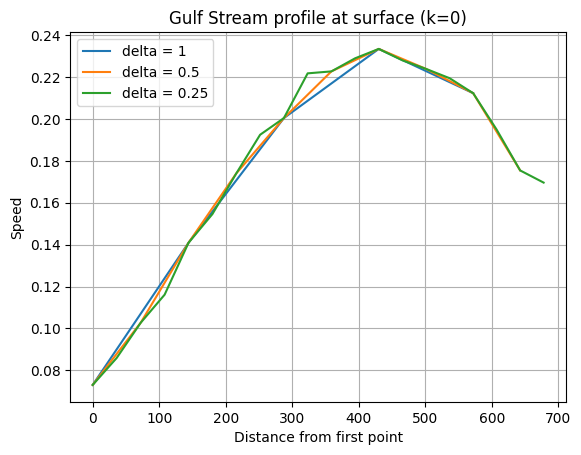

In [9]:
fig, ax = plt.subplots()

for idelta, delta in enumerate(delta_range):
    label = 'delta = ' + str(delta_range[idelta])
    plt.plot(dist_slice[idelta]/1e3, SPEED_slice[idelta], label=label)

plt.xlabel("Distance from first point")
plt.ylabel("Speed")
plt.title("Gulf Stream profile at surface (k=0)")
plt.grid()
plt.legend()